In [1174]:
# %load 'preprocessing.py'
import argparse
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal
import csv

def read_csv(path):

    data_dict = {}

    with open(path, mode='r', newline='') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            key = row[0]
            value = int(row[1])
            data_dict[key] = value

    return data_dict



def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("data_path", help="Path to the dataset")
    args = parser.parse_args()
    return args.data_path

def read_all_images(path):
    images = [path + image for image in listdir(path) if isfile(join(path, image))]
    return images

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def rgb_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def grayscale_to_bin(image):
    _, image_bin = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU-100)
    return image_bin

def blur(image):
    k_size = 5
    k = (1./k_size*k_size) * np.ones((k_size, k_size))
    image_blur = signal.convolve2d(image, k)
    return image_blur

def invert(image):
    return 255-image


def label2rgb(markers):
    cmap = plt.get_cmap('jet', len(np.unique(markers)))
    return cmap(markers)




In [1484]:
path = "pictures/"
image_paths = read_all_images(path)
image_paths

['pictures/ditto_v1_notebook.jpg',
 'pictures/ditto_v7_notebook.jpg',
 'pictures/ditto_v3_notebook.jpg',
 'pictures/ditto_v10_notebook.jpg',
 'pictures/ditto_v6_notebook.jpg',
 'pictures/ditto_v5_notebook.jpg',
 'pictures/ditto_v2_notebook.jpg',
 'pictures/ditto_v4_notebook.jpg',
 'pictures/ditto_v8_notebook.jpg',
 'pictures/ditto_v9_notebook.jpg']

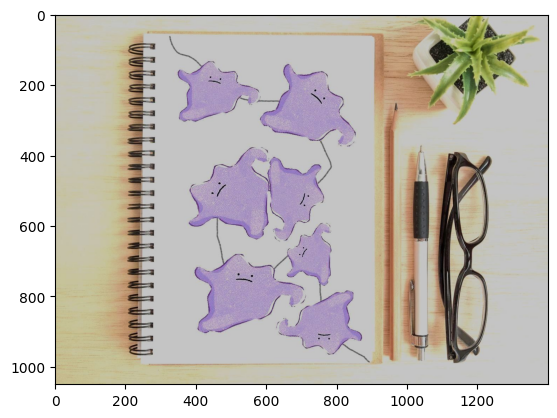

In [1485]:
selected_path_index = -1
path = image_paths[selected_path_index]
image = load_image(path)
display_image(image)


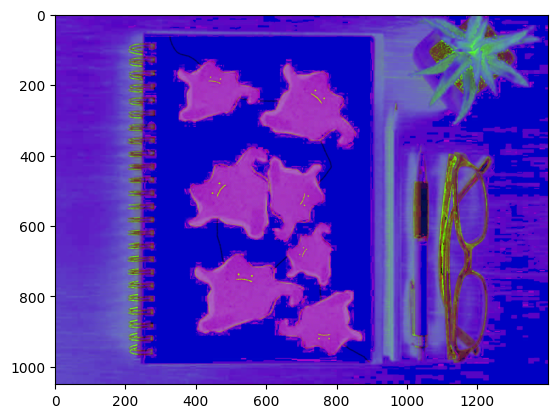

In [1486]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
display_image(hsv_image)

In [1487]:
lower_purple = np.array([130, 40, 50]) 
upper_purple = np.array([180, 200, 220])


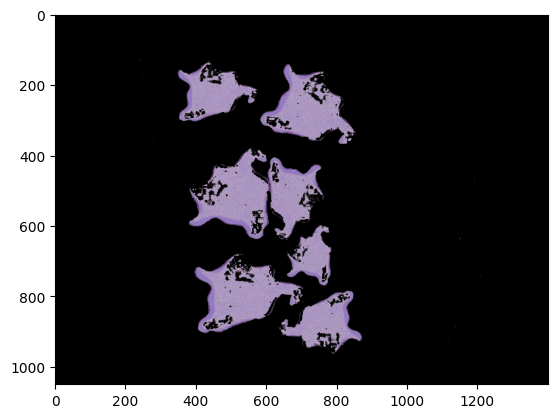

In [1488]:
purple_mask = cv2.inRange(hsv_image, lower_purple, upper_purple)
purple_extracted = cv2.bitwise_and(image, image, mask=purple_mask)
display_image(purple_extracted)

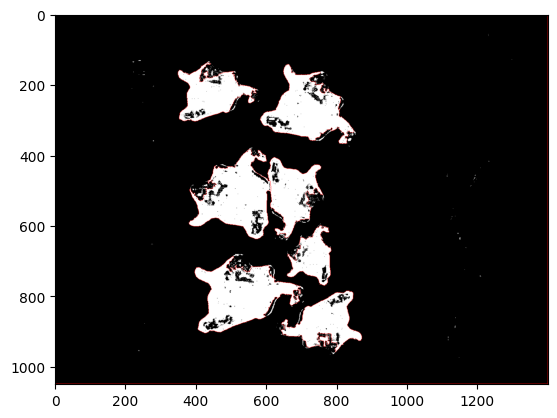

In [1504]:
image = purple_extracted
ret, image_bin = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
display_image(image_bin)

In [1505]:
kernel = np.ones((3,3), np.uint8) # strukturni element 3x3 blok

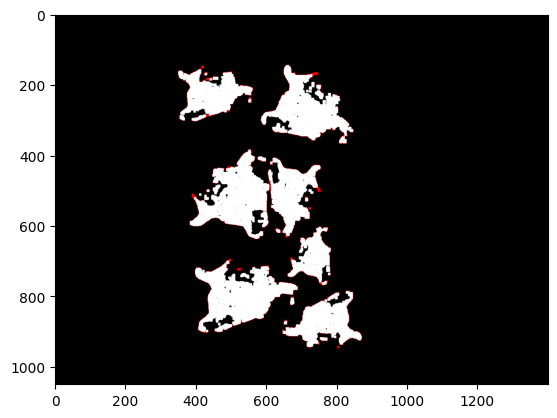

In [1506]:
opening = cv2.morphologyEx(image_bin, cv2.MORPH_OPEN, kernel, iterations = 3) 
display_image(opening)

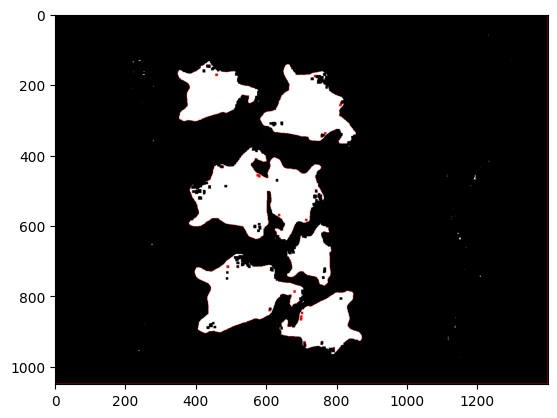

In [1507]:
closing = cv2.morphologyEx(image_bin, cv2.MORPH_CLOSE, kernel, iterations = 3)
display_image(closing)

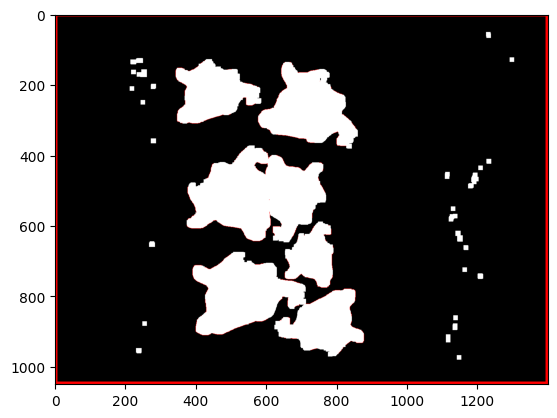

In [1508]:
dilation = cv2.morphologyEx(image_bin, cv2.MORPH_DILATE, kernel, iterations = 6) 
display_image(dilation)

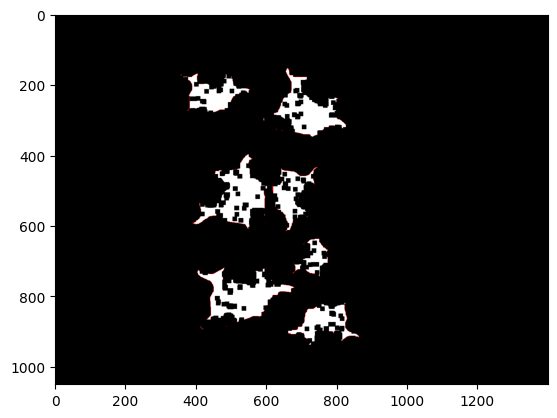

In [1509]:
erosion = cv2.morphologyEx(image_bin, cv2.MORPH_ERODE, kernel, iterations = 6) 
display_image(erosion)

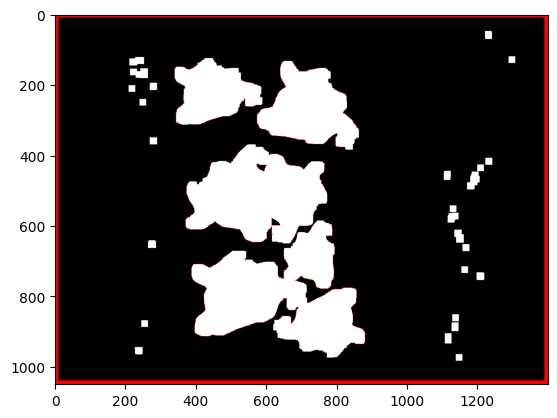

In [1510]:
sure_bg = cv2.dilate(dilation, kernel, iterations=3)
display_image(sure_bg)

In [1511]:
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, maskSize=5) 
display_image(dist_transform)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/distransform.cpp:725: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'distanceTransform'


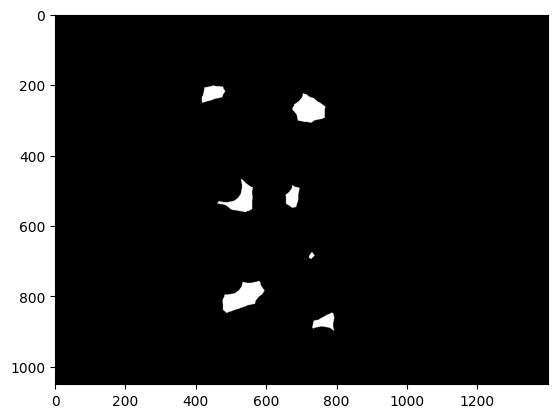

In [ ]:
ret, sure_fg = cv2.threshold(dist_transform, 0.55 * dist_transform.max(), 255, 0) 
display_image(sure_fg)

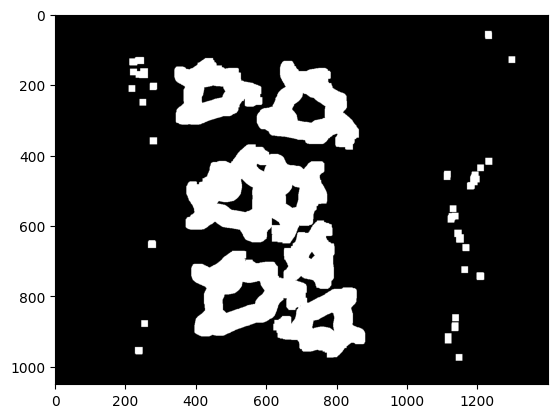

In [ ]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
display_image(unknown)

In [ ]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

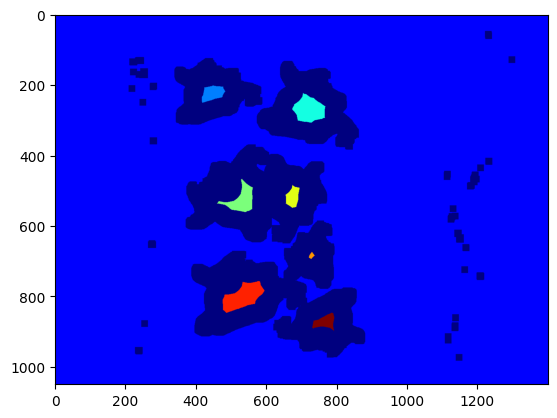

In [ ]:
rgba_img = label2rgb(markers)
display_image(rgba_img, color=True)

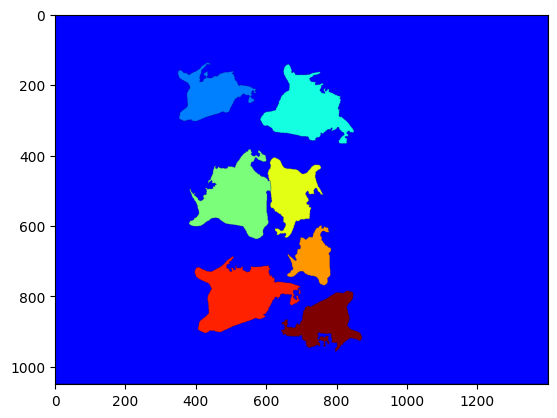

In [1512]:
markers = cv2.watershed(image_bin, markers)
image_bin[markers == -1] = [255, 0, 0]
rgba_img = label2rgb(markers)
display_image(rgba_img, color=True)

In [1513]:
unique_colours = {x for l in markers for x in l}

In [1514]:
number_of_dittos = len(unique_colours) - 2
print("Broj detektovanih Ditto-a:", number_of_dittos)

Broj detektovanih Ditto-a: 7
